# Infill stylised pathway
Here we generate a portfolio of stylised CO2 pathways and infill them with other gases. Pathways are generated based on the functional form suggested in "What would it take to achieve the Paris temperature targets?" (Sanderson et al, 2016)

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import numpy as np
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    download_or_load_sr15,
    convert_units_to_MtCO2_equiv
)
import silicone.multiple_infillers as mi

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


# Download data
We use the SR1.5 database to perform our infilling and use the CMIP5 database to provide the RCP8.5 and RCP2.6 pathways required by the stylised path equations. 

In [2]:
sr15_file = "./../Input/complete_sr15.csv"
download_or_load_sr15(sr15_file)    

# We are only interested in the worldwide record
df = pyam.IamDataFrame(sr15_file).filter(region="World") 
df.head()

pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`
pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,0,0.0,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,0,0.0,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,0,0.0,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,0,0.0,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,0,0.0,5.8486


In [3]:
rcmip_file = "./../Input/DownloadedRCMIP_RCP85_26Datat.csv"
rcmip_df = pyam.IamDataFrame(rcmip_file)

pyam.utils - INFO: Reading `./../Input/DownloadedRCMIP_RCP85_26Datat.csv`


Our basic input has separate functional forms for CO2 from land use and total CO2. We will base our pathway on the AIM/CGE 2.0 model. It requires three free parameters, $\tau$ (a decay constant), $t_m$ (a time to start the transition) and $E_\infty$, the long-run total CO2 emissions. There are two additional parameters defined by continuity conditions, $A$ and $t_e$. Note that we will slightly redefine A from the paper so that $E_{CO_2} = A(t-t_e)E^{-(t-t_e)/\tau}-E_\infty$. 

We will arbitrarily select $t_m = 2025, \tau = 10$ or 30 and $E_\infty = \pm 3400$ (The negative case is around the 2150 limit of the RCP2.6 scenario)

In [4]:
rcmip_df.filter(variable="Emissions|CO2", year=2150).data.head()

,model,scenario,region,variable,unit,year,value
543,IMAGE,rcp26,World,Emissions|CO2,Mt CO2/yr,2150,-3412.933333
5983,MESSAGE,rcp85,World,Emissions|CO2,Mt CO2/yr,2150,105380.000000


In [5]:
taus = [10, 30]
t_m = 2025
E_infs = [3400, -3400]
t_max = 2100

We can construct the basis of the paths to infill

In [6]:
construct = rcmip_df.filter(scenario="rcp85", year=range(t_m))
ELU85 = rcmip_df.filter(
    variable="Emissions|CO2|MAGICC AFOLU", scenario="rcp85", year=range(t_m, t_max + 1)
)
ELU26 = rcmip_df.filter(
    variable="Emissions|CO2|MAGICC AFOLU", scenario="rcp26", year=range(t_m, t_max + 1)
)
ELU85.data.reset_index(inplace=True, drop=True)
ELU26.data.reset_index(inplace=True, drop=True)
ELU26.head()

,model,scenario,region,variable,unit,year,value
0,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2025,3229.783333
1,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2026,3162.353333
2,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2027,3094.923333
3,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2028,3027.493333
4,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2029,2960.063333


In [7]:
constructed_df = None
def scenario_fn(tau, E_inf):
    return "tau_" + str(tau) + "_E-inf_" + str(E_inf)
def AFOLU_fn(t, t_m, tau, E85, E26):
    return E85 * np.exp(-(t - t_m) / tau)  + E26 * (1 - np.exp(-(t - t_m) / tau))
for tau in taus:
    for E_inf in E_infs:
        output = construct.copy()
        to_add = ELU85.copy()
        to_add["value"] = AFOLU_fn(ELU85["year"], t_m, tau, ELU85["value"], ELU26["value"])
        output.append(to_add, inplace=True)
        output["scenario"] = scenario_fn(tau, E_inf)
        if constructed_df:
            constructed_df.append(output, inplace=True)
        else:
            constructed_df = pyam.IamDataFrame(output.data)

In [8]:
constructed_df=pyam.IamDataFrame(constructed_df.data)
constructed_df.filter(variable="*CO2|MAGICC A*").data

,model,scenario,region,variable,unit,year,value
40,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2015,3575.366667
41,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2016,3525.060000
42,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2017,3474.753333
43,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2018,3424.446667
44,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2019,3374.140000
...,...,...,...,...,...,...,...
1549,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2096,1862.584019
1550,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2097,1833.098929
1551,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2098,1803.513626
1552,MESSAGE,tau_30_E-inf_3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2099,1773.830472


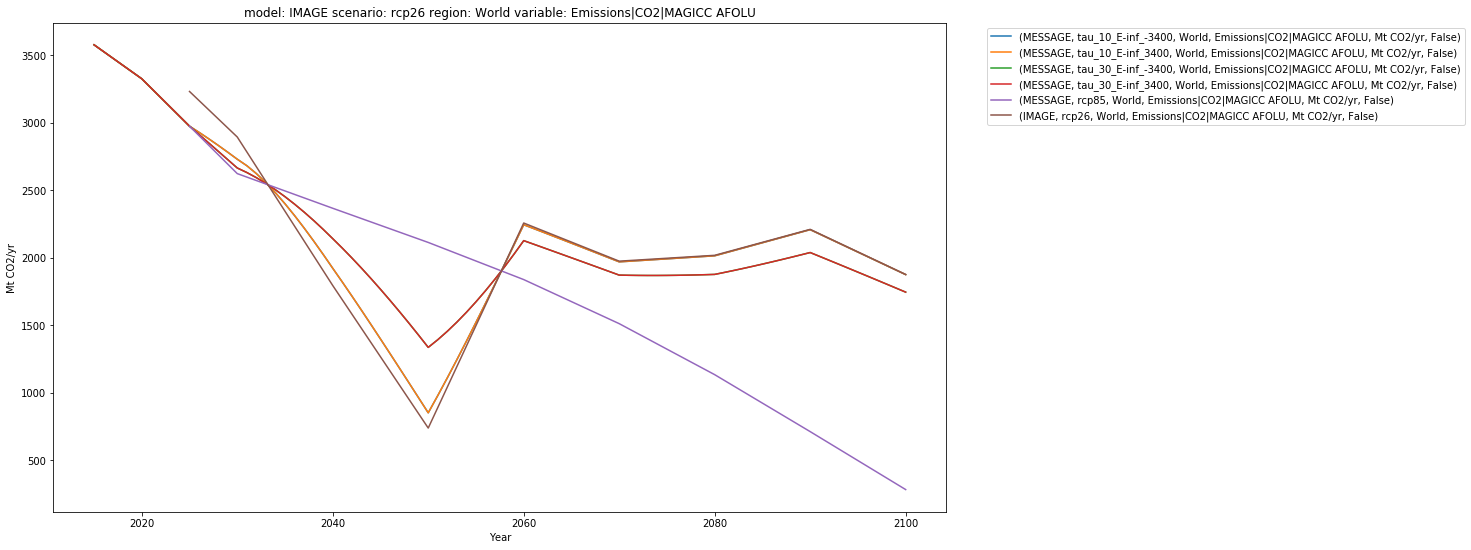

In [9]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable="Emissions|CO2|MAGICC AFOLU").line_plot(ax=ax)
ELU85.line_plot(ax=ax)
ELU26.line_plot(ax=ax)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [10]:
ELU85.data

,model,scenario,region,variable,unit,year,value
0,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2025,2972.750000
1,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2026,2902.533333
2,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2027,2832.316667
3,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2028,2762.100000
4,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2029,2691.883333
...,...,...,...,...,...,...,...
71,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2096,453.933333
72,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2097,411.033333
73,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2098,368.133333
74,MESSAGE,rcp85,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2099,325.233333


In [11]:
def ETOT_fn(t, t_m, tau, t_e, A, E_inf):
    return A * (t-t_e) * np.exp(-(t-t_m)/tau) - E_inf
t_step = 1
ETOT_86 = rcmip_df.filter(
    variable="Emissions|CO2", scenario="rcp85", year=range(t_m - t_step, t_m + t_step + 1)
).data.set_index("year")
for tau in taus:
    for E_inf in E_infs:
        output = ELU85.copy()
        # A = dE/dt - (E+E_inf)/\tau at t_m
        A = (ETOT_86["value"].loc[t_m + t_step] - ETOT_86["value"].loc[t_m - t_step]) / (2 * t_step) \
            - (ETOT_86["value"].loc[t_m] + E_inf) / tau
        t_e = t_m - (ETOT_86["value"].loc[t_m] + E_inf) / A
        output["value"] = ETOT_fn(np.arange(t_m, t_max + 1), t_m, tau, t_e, A, E_inf)
        output["scenario"] = scenario_fn(tau, E_inf)
        output["variable"] = "Emissions|CO2"
        constructed_df.append(output, inplace=True)

NameError: name 'constructed_dfs' is not defined

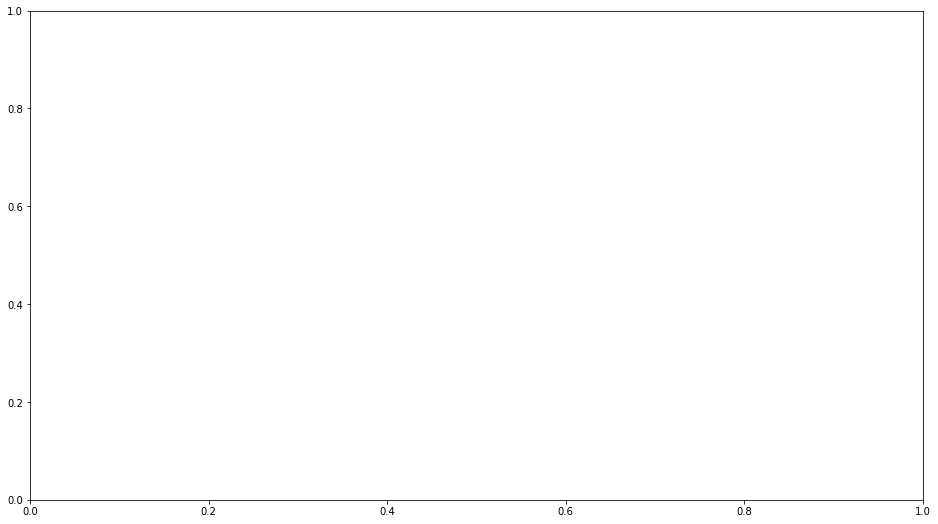

In [12]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_dfs.filter(variable="Emissions|CO2").line_plot(ax=ax)